# Detection of heart arrythmia via ECG Signal using deep nural network



In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import regularizers


%matplotlib inline

2025-04-20 08:28:14.825889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745137695.021276      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745137695.084401      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


* **N (Normal):** The "N" represents a normal heartbeat or cardiac complex. It indicates that the electrical activity of the heart is within the normal range, and there are no abnormalities or irregularities in the heart rhythm.
* **L (Left bundle branch block):** An "L" complex indicates the presence of a left bundle branch block. This is an abnormality in the electrical conduction system of the heart, where the electrical signals do not travel normally through the left bundle branch. It can affect the timing and coordination of ventricular contractions.
* **R (Right bundle branch block):** An "R" complex indicates a right bundle branch block. Similar to left bundle branch block, this signifies an abnormality in the electrical conduction system involving the right bundle branch.
* **A (Atrial premature beat):** An "A" complex represents an atrial premature beat, which is an early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.
* **V (Ventricular premature beat):** A "V" complex represents a ventricular premature beat, which is an early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.


In [ ]:
path = 'Sample dataset'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [5]:
count_classes

[0, 0, 0, 0, 0]

In [6]:
# Read files
filenames = next(os.walk(path))[2] # Use os.walk() to get a list of all files in the directory specified by the path variable. [2] returns a list of file names in that directory.

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(os.path.join(path, filename + file_extension))

    # *.txt
    else:
        annotations.append(os.path.join(path, filename + file_extension))
print(records[0])
print(annotations[0])

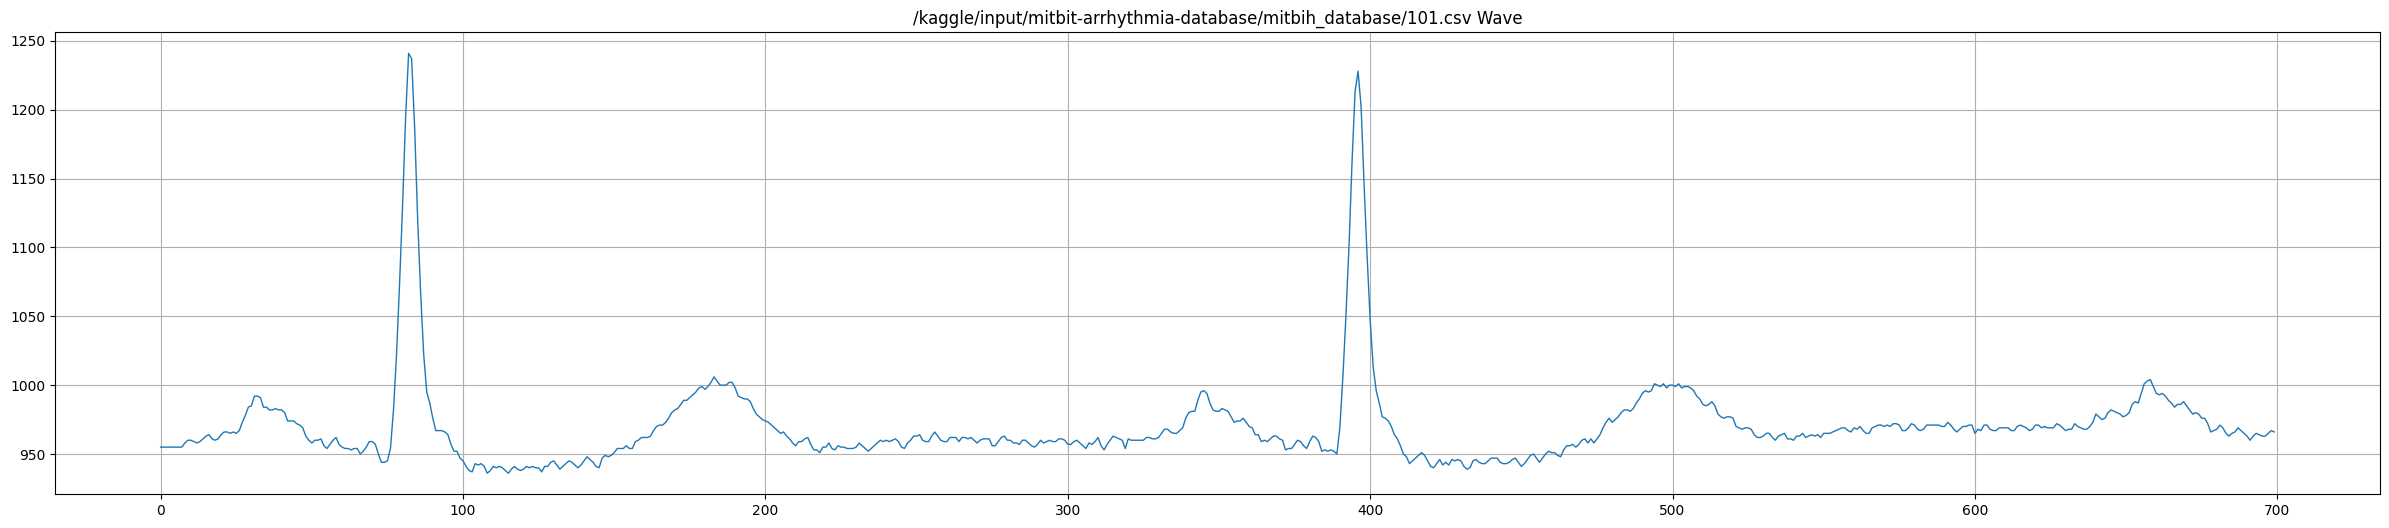

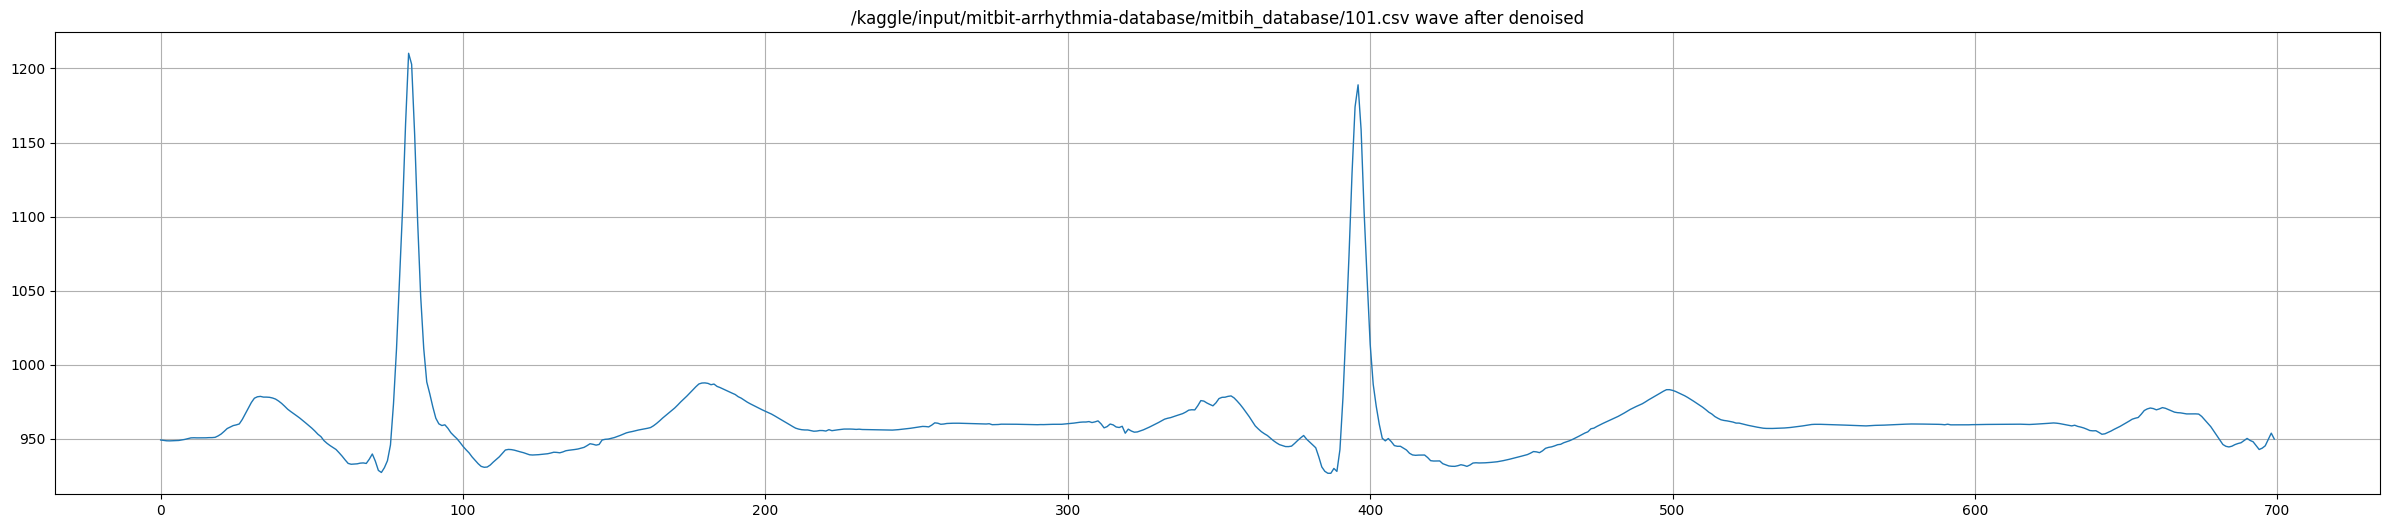

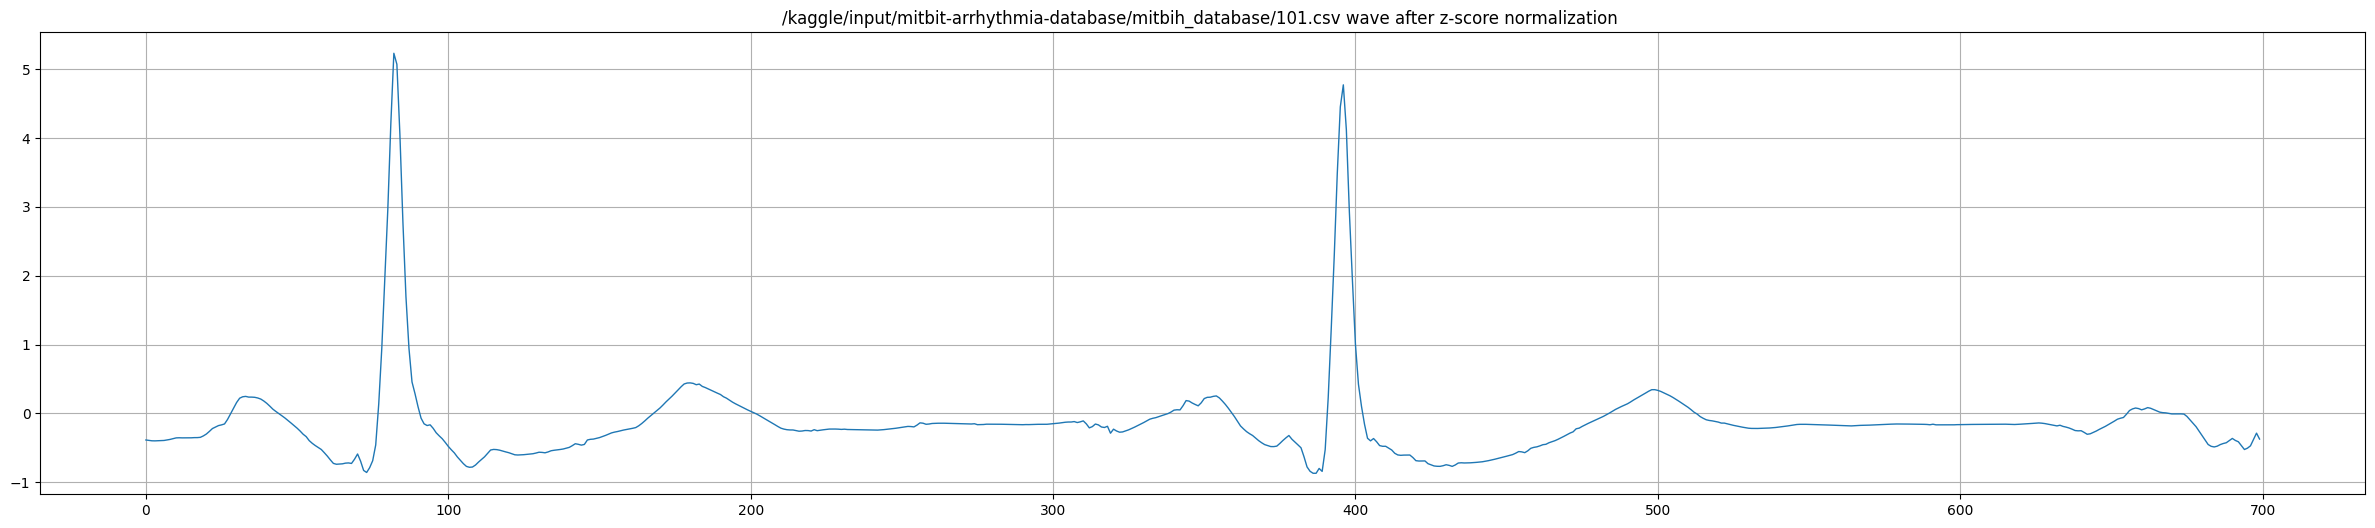

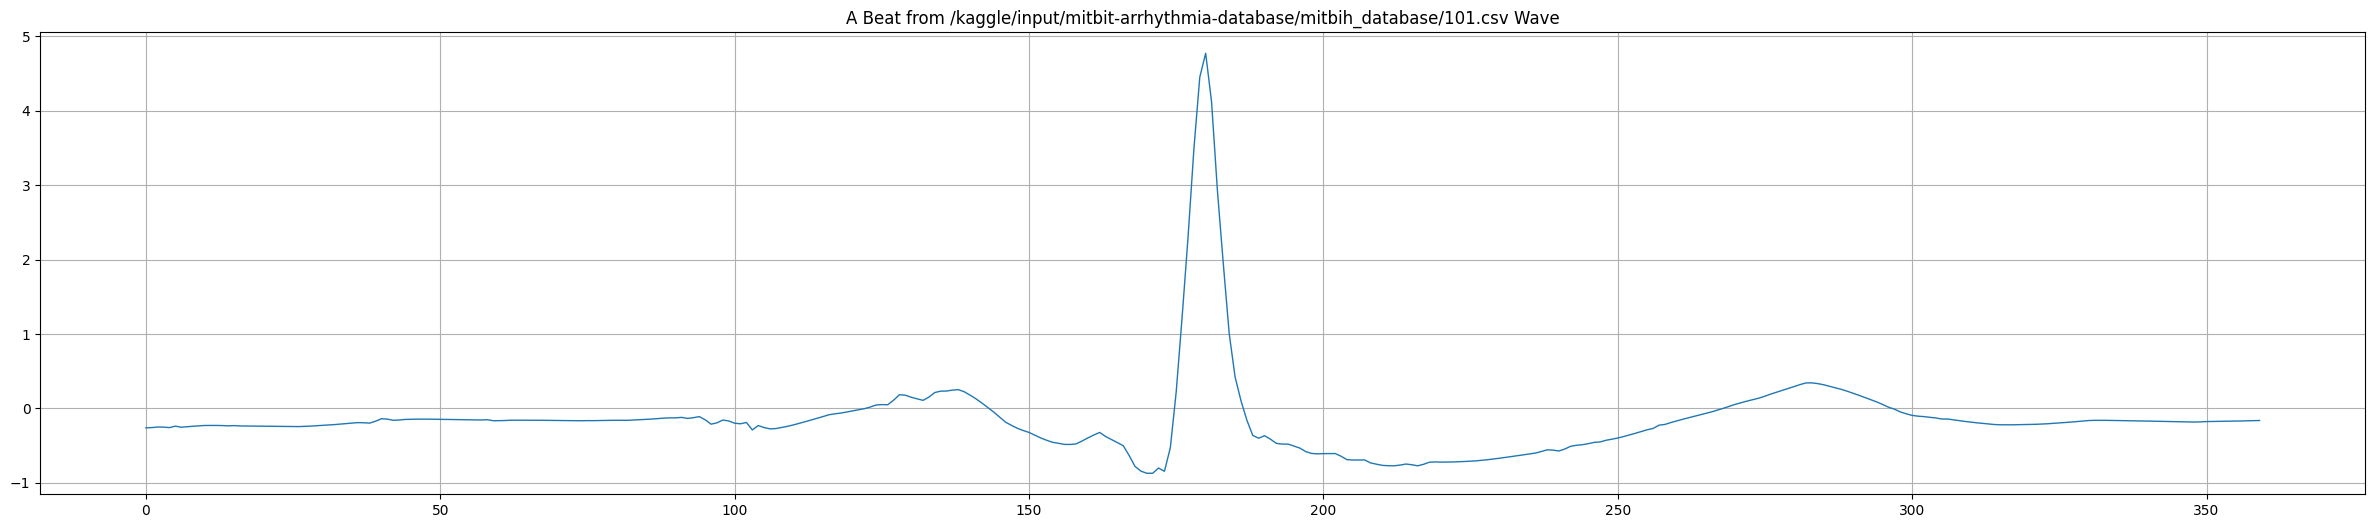

(100012, 360) (100012,)


In [11]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [13]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))


(100012, 361)


360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


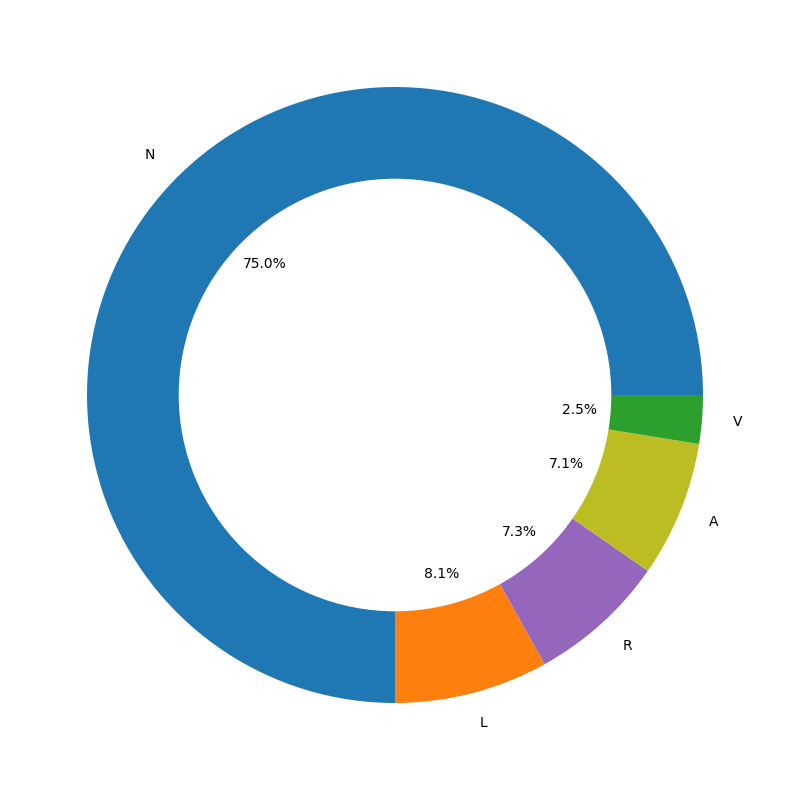

In [15]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [18]:
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==2])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==3])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==4])

            0         1         2         3         4         5         6    \
12896 -0.401492 -0.396007 -0.390960 -0.385979 -0.381117 -0.376737 -0.369812   
12897 -0.939916 -0.937393 -0.943008 -0.951025 -0.932181 -0.906635 -0.912234   
12898 -1.649192 -1.647320 -1.642994 -1.636105 -1.626842 -1.615760 -1.602437   
12899 -1.905637 -1.887726 -1.866577 -1.845727 -1.823928 -1.799773 -1.774578   
12900 -1.403907 -1.382955 -1.382825 -1.382793 -1.395068 -1.368718 -1.362371   
...         ...       ...       ...       ...       ...       ...       ...   
71349 -0.738139 -0.737439 -0.730995 -0.724577 -0.717292 -0.713160 -0.709915   
71351 -0.141920 -0.137517 -0.154152 -0.159583 -0.167618 -0.163239 -0.174605   
71352 -0.749901 -0.733211 -0.720466 -0.705497 -0.690559 -0.674002 -0.657000   
71353 -0.542969 -0.536522 -0.528808 -0.518250 -0.524179 -0.533625 -0.516716   
71354 -0.636275 -0.654150 -0.659389 -0.683285 -0.694627 -0.710673 -0.700268   

            7         8         9    ...       351 

In [19]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


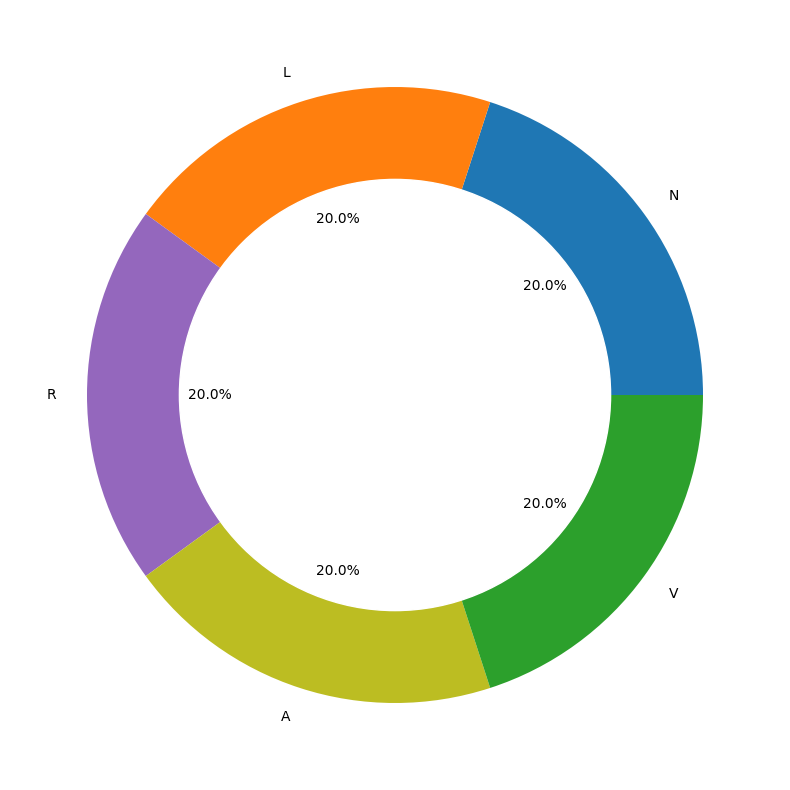

In [20]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [21]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [22]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [24]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))
print(np.shape(train_y),np.shape(test_y))

(20000, 360, 1) (5000, 360, 1)
(20000, 5) (5000, 5)


In [25]:
from keras.layers import MaxPooling1D as MaxPool1D
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=train_x[0].shape))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745137756.655812      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 360, 16)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 179, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 179, 32)             │           7,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 89, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 89, 64)              │          34,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 44, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 44, 128)             │         155,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │          94,115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Softmax)                    │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292,887 (1.12 MB)

 Trainable params: 292,887 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [27]:
history = model.fit(train_x, train_y, batch_size=75, epochs=50, verbose=1, validation_data=(test_x, test_y))

Epoch 1/50


I0000 00:00:1745137761.584143      61 service.cc:148] XLA service 0x7876fc00ca20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745137761.584594      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745137761.928545      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 28/267 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4901 - loss: 1.2283

I0000 00:00:1745137764.851793      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7852 - loss: 0.5824 - val_accuracy: 0.9552 - val_loss: 0.1430
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9557 - loss: 0.1420 - val_accuracy: 0.9740 - val_loss: 0.0927
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9678 - loss: 0.1069 - val_accuracy: 0.9770 - val_loss: 0.0835
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9775 - loss: 0.0747 - val_accuracy: 0.9798 - val_loss: 0.0685
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9814 - loss: 0.0663 - val_accuracy: 0.9824 - val_loss: 0.0655
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9810 - loss: 0.0679 - val_accuracy: 0.9838 - val_loss: 0.0584
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9839 - loss: 0.0649 - val_accuracy: 0.9842 - val_loss: 0.0607
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9838 - loss: 0.0578 - val_accuracy: 0.9868 - va

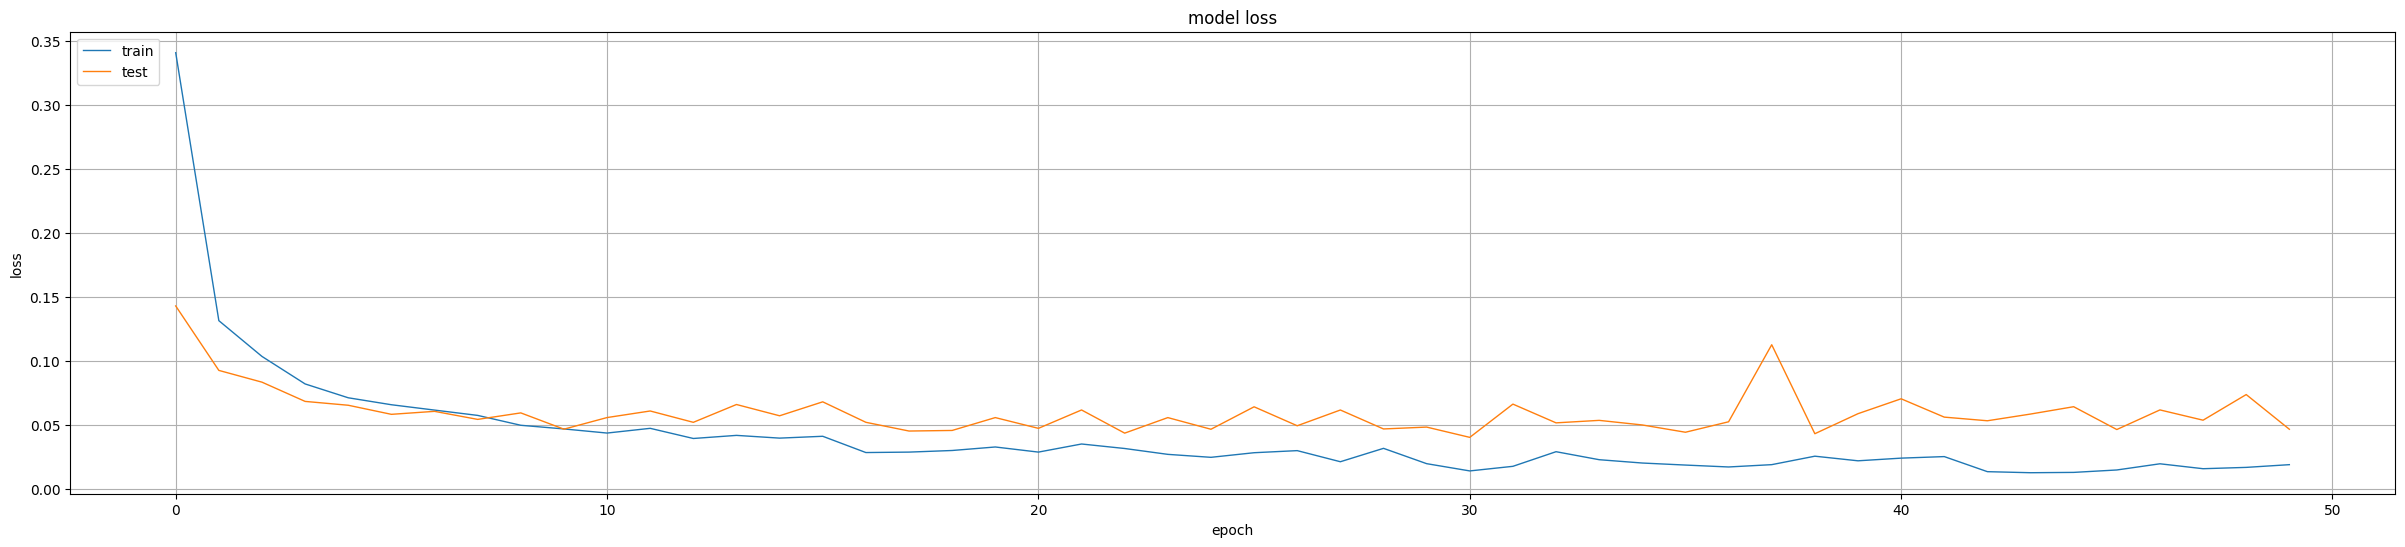

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

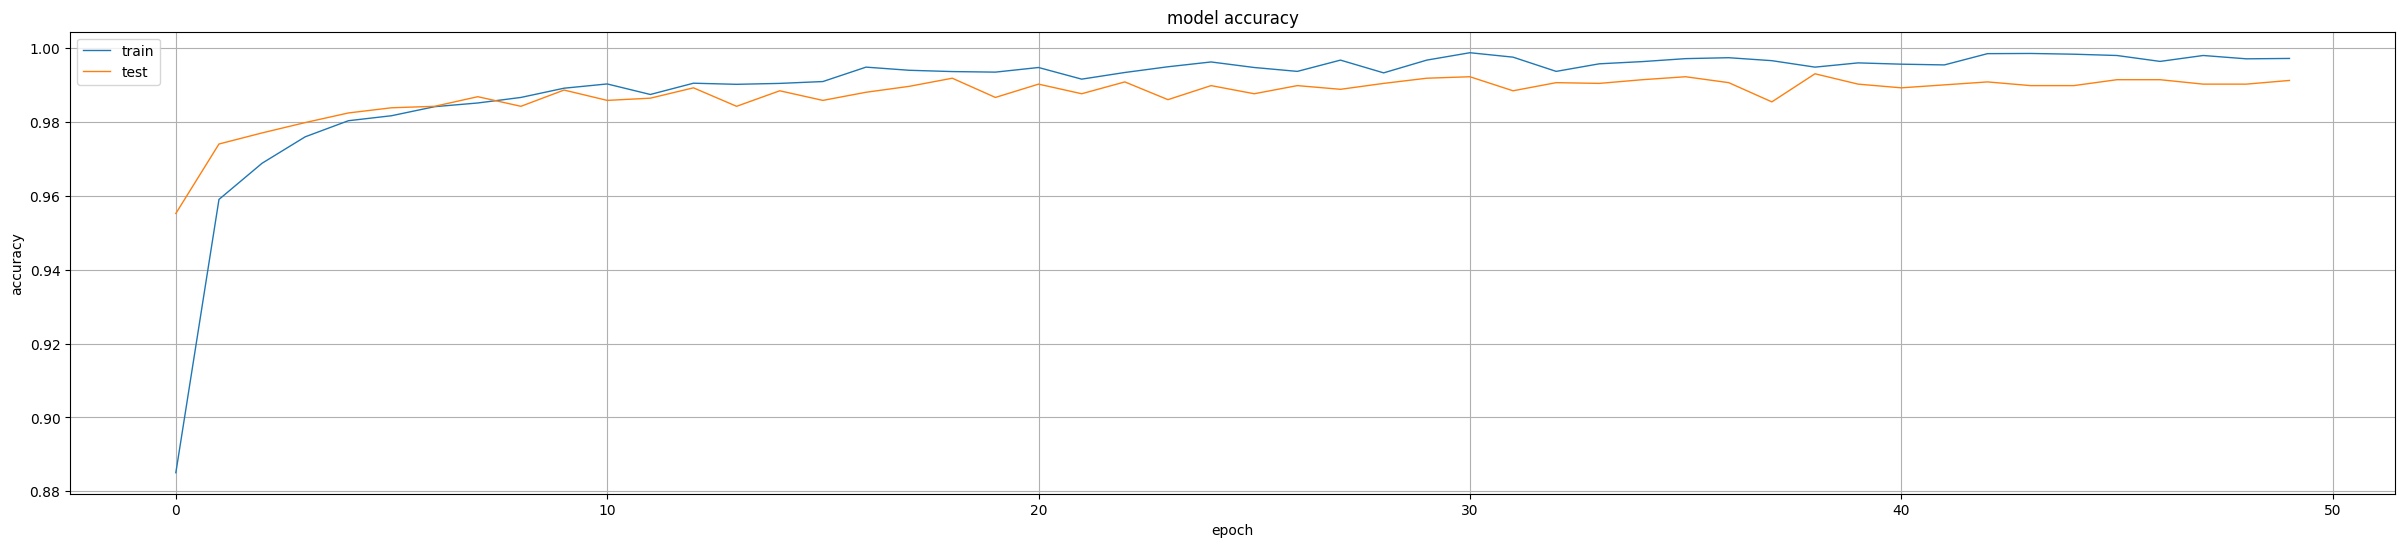

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.save(f'arryhtmia-classification-{window_size}.h5')

In [31]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9911 - loss: 0.0467
Test Loss: 0.04676852747797966
Test accuracy: 0.9911999702453613


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


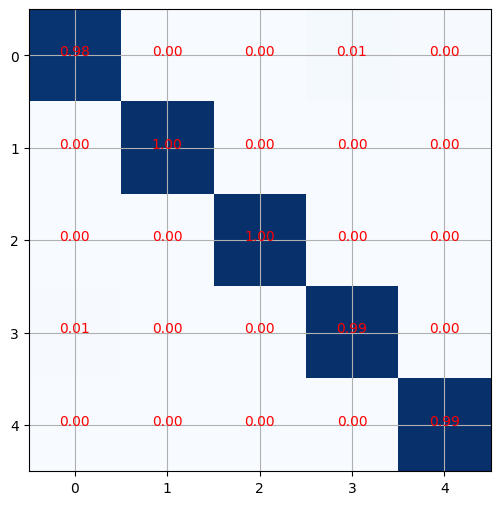

In [32]:
from sklearn.metrics import f1_score, confusion_matrix
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="red")


plt.imshow(cm, cmap=plt.cm.Blues)

In [33]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[X_train_df.shape[1]-1].value_counts())

print('F1_score = ', f1_score(test_y.argmax(axis=1), pred_y.argmax(axis=1), average = 'macro'))


The distribution of test set labels
360
1.0    1050
4.0    1050
0.0     986
3.0     965
2.0     949
Name: count, dtype: int64
F1_score =  0.9911460182075909


Actual label:  N
Model prediction :  N  with probability  0.99986076


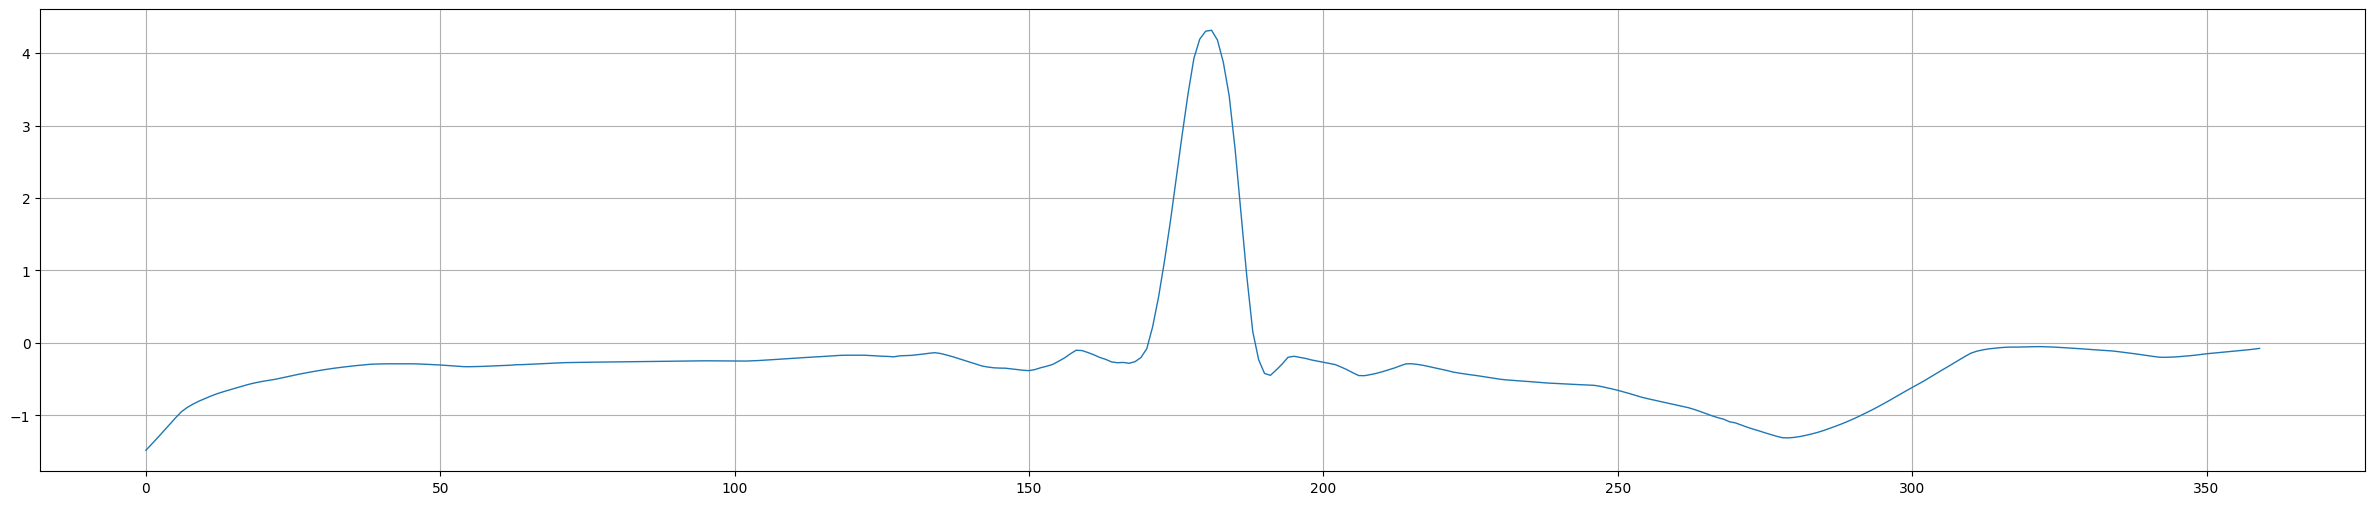

In [34]:
import random
i = random.randint(0, len(test_x)-1)

output = model(np.expand_dims(test_x[i], 0))

pred = output.numpy()[0]

plt.plot(test_x[i])

print("Actual label: ", classes[np.argmax(test_y[i])])
print("Model prediction : ", classes[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])